# Fortran Tests and Fortran-Python Integration
### Group 4 - LaGrange
Mark Croom, Hannah Gallamore, Dylan Gatlin, Cristo Sanchez

In [31]:
import numpy as np
import fortpy as fp
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

## Init Functions

In [32]:
class Output(object):
    def __init__(self, masses=[], positions=[], velocities=[], times=[],
                 coms=[], avvs=[], energies=[], amomentums=[],
                 eccentricities=[], count=0, n_bodies=0):
        self.masses = masses
        self.positions = positions
        self.velocities = velocities
        self.times = times
        self.coms = coms
        self.avvs = avvs
        self.energies = energies
        self.amomentums = amomentums
        self.eccentricities = eccentricities
        self.count = count
        self.n_bodies = n_bodies
        self.model_out = [self.masses, self.positions, self.velocities,
                          self.times, self.coms, self.avvs, self.n_bodies]

    def calculate_auxilary_values(self, com=None, avv=None):
        """Computes the energy and angular momentum of a system of particles.
        The energy is computed as the kinetic energy of a particle minus the
        potential energy of every other particle relative to it. The angular
        momentum is the cross product of positions and velocities, relative to 
        the center of mass.
        """
        if com is None:
            com = self.coms
        if avv is None:
            avv = self.avvs
        nrg_rel = np.zeros(self.positions.shape[0])
        h_rel = np.zeros((self.positions.shape[0],) + (3,))

        for i in range(self.positions.shape[1]):
            # if masses[i] != 0:
            nrg_rel += 0.5 * np.linalg.norm(self.velocities[:, i, :]
                                            - avv, axis=1)**2
            for j in range(i+1, self.positions.shape[1]):
                # if masses[i] != 0:
                nrg_rel -= self.masses[i] / np.linalg.norm(
                    self.positions[:, i, :] - self.positions[:, j, :], axis=1
                    )
            h_rel += np.cross(self.positions[:, i, :] - com,
                              self.velocities[:, i, :] - avv)
        e_rel = np.sqrt(1 + 2 * nrg_rel * np.linalg.norm(h_rel, axis=1)
                        / np.sum(self.masses)**2)
        self.eccentricities = e_rel
        self.energies = nrg_rel
        self.amomentums = h_rel


def calc_com(masses, pos):
    """A simple function that compute the center of mass of a system
    """
    return (masses[:, None] * pos).sum(axis=0) / masses.sum()
    # return ((masses*pos.T).T).sum(axis = 0) / masses.sum()


def calc_avv(masses, vel):
    """A simple function that computes the average velocity of a system
    """
    return (masses[:, None] * vel).sum(axis=0) / masses.sum()
    # return ((masses*vel.T).T).sum(axis = 0) / masses.sum()


def adjust_timestep(dt, err, q, t_tot):
#     facmax = 6.
#     facmin = 0.33
    fac = 0.38**(1. / (1. + q))
    dt_new = dt * fac * err**(-1. / (1. + q))
#     if (dt_new > facmax * dt):
#         dt_new = facmax * dt
#     elif (dt_new < facmin * dt):
#         dt_new = facmin * dt
    if (dt_new / t_tot < 1e-12) or np.isnan(dt_new):
        dt_new = t_tot * 1e-12
    return dt_new


def adaptive_n_body(integrator, masses, i_positions, i_velocities,
                    t_tot, tolerance, dt_0=1e-2, q=2, update_com=True,
                    **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs, and returns
     a pair of positions and velocities, the first two are the lower-order
     positions and velocities, the second pair is the higher-order check of the
     positions and velocities
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    times = []
    positions = []
    velocities = []
    coms = []
    avvs = []
    errors = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos2 = i_positions - com
        vel2 = i_velocities - avv
    else:
        pos2 = i_positions
        vel2 = i_velocities
    t = 0.
    dt = dt_0
    err = 0.
    count = 0
    pbar = tqdm.tqdm(total=t_tot,bar_format='{desc}: {percentage:3.0f}'
    '% {n:.3f}/{total:.3f} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
    n_recalculates = 0
    while ((t < t_tot) and (count < 1000000)):
        pbar.update(dt)
        times.append(t)
        positions.append(pos2)
        velocities.append(vel2)
        coms.append(com)
        avvs.append(avv)
        errors.append(err)
#         second_count = 0
#         while second_count < 100:
        pos1, vel1, pos2, vel2 = integrator(masses, pos2, vel2, dt,
                                                **kwargs)
            # To handle most critical bugs in any integrator function, this will
            # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos2)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos2)
        avv = calc_avv(masses, vel2)
        if update_com:
            pos2 -= com
            vel2 -= avv
        
        # Adjust timestep
        err = np.concatenate((pos1 - pos2, vel1 - vel2))
        err = np.linalg.norm(err / tolerance) / np.sqrt(err.size)
    
        dt = adjust_timestep(dt, err, q, t_tot)
        # if err <= 1:  # Happens when the solution is accurate enough
        #     break
        # 
        # second_count += 1
        # if second_count > 10:
        #     print('Recalculated for more than 10 loops')
        # n_recalculates += second_count
        t += dt

        count += 1
    pbar.close()
    times = np.array(times)
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    errors = np.array(errors)
    out = Output(masses=masses, positions=positions, velocities=velocities,
                 times=times, coms=coms, avvs=avvs,
                 count=count, n_bodies=len(masses))
    out.errors = errors
    return out


def n_body(integrator, masses, i_positions, i_velocities, t_tot, dt,
           update_com=True, **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    n_steps = int(t_tot / dt)
    times = np.linspace(0., t_tot, n_steps + 1)
    positions = []
    velocities = []
    coms = []
    avvs = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos = i_positions - com
        vel = i_velocities - avv
    else:
        pos = i_positions
        vel = i_velocities
    for i, time in tqdm.tqdm(list(enumerate(times))):
        positions.append(pos)
        velocities.append(vel)
        coms.append(com)
        avvs.append(avv)
        out = integrator(masses, pos, vel, dt, **kwargs)
        if len(out) == 2:
            pos, vel = out
        elif len(out) == 4:
            pos, vel = out[:2]
            # In case you're using an adaptive integrator in 
            #n_body, this will allow it to run (good for testing)
        # To handle most critical bugs in any integrator function, this will
        # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos)
        avv = calc_avv(masses, vel)
        if update_com:
            pos -= com
            vel -= avv
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    return Output(masses, positions, velocities, times, coms, avvs,
                  count=n_steps + 1, n_bodies=len(masses))


def euler_forward(masses, positions, velocities, dt, G=1):
    """An euler-forward (often just called euler) integrating scheme. It is
     simple and fast, but not very accurate.
    
    Warning: this was written for speed in a simple 2-body 3D system. In order
     to work on a more general system, it may need to be rewritten.
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
    vels = np.zeros(positions.shape)
    poses = np.zeros(positions.shape)
    accels = np.zeros(positions.shape)
    for i, pos in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i != j:
                if masses[j] != 0:
                    r = pos2 - pos
                    accels[i] += G * masses[j] / np.linalg.norm(r)**3 * r
        vels[i] = velocities[i] + accels[i] * dt
        poses[i] = positions[i] + velocities[i] * dt
    return poses, vels


def rk_pde(masses, positions, velocities, G=1):
    """Returns velocities and accelerations of a body at a given
    position. Used inside the Runge-Kutta Methods
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
    
    k_vels = np.zeros(positions.shape)
    k_poses = velocities.copy()

    for i, pos in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i != j:
                if masses[j] != 0:
                    r = pos2 - pos
                    k_vels[i] += G * masses[j] / np.linalg.norm(r)**3 * r
        
    return k_poses, k_vels
    

def kick_drift_kick(masses, positions, velocities, dt, G=1):
    """A kick-drift-kick integrating scheme. Each time step really involves
     two gravity calculations, so this is approximately twice as intensive
     as an euler integration scheme, although it is accurate to dt**4
    """
    accels = np.zeros(positions.shape)
    vels = np.zeros(positions.shape)
    poses = np.zeros(positions.shape)
    for i, pos in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i != j: 
                if masses[j] != 0:

                    r = pos2 - pos
                    accels[i] += G * masses[j] / np.linalg.norm(r)**3 * r
        vels[i] = velocities[i] + accels[i] * dt / 2 #kick
        poses[i] = pos + vels[i] * dt #drift

    # Need to re-zero the accelerations before the final kick
    accels = np.zeros(positions.shape) 
    for i, pos in enumerate(poses): # Now we are looping through the poses
    # array instead of positions as positions was the initial positions
        for j, pos2 in enumerate(poses):
            if i != j:
                if masses[j] != 0:
                    r = pos2 - pos
                    accels[i] += masses[j] / np.linalg.norm(r)**3 * r
        vels[i] = vels[i] + accels[i] * dt / 2 #kick
    return poses, vels


def kick_drift_kick_galaxy(masses, positions, velocities, dt, G=1):
    """A kick-drift-kick integrating scheme. Each time step really involves
     two gravity calculations, so this is approximately twice as intensive
     as an euler integration scheme, although it is accurate to dt**4
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
     
    accels = np.zeros(positions.shape)
    vels = velocities.copy()
    poses = np.zeros(positions.shape)
    for i, pos in enumerate(positions):
        r = np.linalg.norm(pos)
#         print(pos)
        accels[i] = (-np.log(1+r) / r**2 + 1 / r / (1+r)) * (pos/r)
#         print(accels[i])
        vels[i] += accels[i] * dt / 2 #kick
#         print(vels[i])
        poses[i] = pos + vels[i] * dt #drift
        # print(accels[i], vels[i])

    # Need to re-zero the accelerations before the final kick
    accels = np.zeros(positions.shape) 
    for i, pos in enumerate(poses):
        r = np.linalg.norm(pos)
        accels[i] = (-np.log(1+r) / r**2 + 1 / r / (1+r)) * (pos/r)    
        vels[i] += accels[i] * dt / 2 #kick
        # print(accels[i], vels[i])
    return poses, vels


def runge_kutta(masses, positions, velocities, dt, G=1):
    k_poses = np.zeros((4,) + positions.shape)
    k_vels = np.zeros((4,) + positions.shape)
    coefficients = np.array([[0.5, 0., 0.],
                             [0., 0.5, 0.],
                             [0., 0., 1.]])
    weights = np.array([1., 2., 2., 1.]) / 6.
    k_poses[0], k_vels[0] = rk_pde(masses, positions, velocities, G=G)
    for i, coeffs in enumerate(coefficients):
        k_poses[i + 1], k_vels[i + 1] = rk_pde(masses,
            positions + (k_poses[:-1] * coeffs[:, None, None] * dt).sum(axis=0),
            velocities + (k_vels[:-1] * coeffs[:, None, None] * dt).sum(axis=0),
                                               G=G)
    poses = positions + (dt * weights[:, None, None] * k_poses).sum(axis=0)
    vels = velocities + (dt * weights[:, None, None] * k_vels).sum(axis=0)

    return poses, vels

def kdk_rk(*args, **kwargs):
    p1, v1 = kick_drift_kick(*args, **kwargs)
    p2, v2 = runge_kutta(*args, **kwargs)
    return p1, v1, p2, v2

def rkf45(masses, positions, velocities, dt, **kwargs):
    k_poses = np.zeros((6,) + positions.shape)
    k_vels = np.zeros((6,) + positions.shape)
    coefficients = np.array([[1. / 4., 0., 0., 0,  0.],
                            [3. / 32., 9. / 32., 0., 0., 0.],
                            [1932. / 2197., -7200. / 2197., 7296. / 2197., 0.,
                             0.],
                            [439. / 216., -8, 3680. / 513., -845. / 4104., 0.],
                            [-8. / 27., 2., -3544. / 2565., 1859. / 4104.,
                             -11. / 40.]])
    weights_4 = np.array([25. / 216, 0., 1408. / 2565., 2197. / 4104., -0.2,
                          0.])
    weights_5 = np.array([16. / 135., 0.,6656. /12825., 28561. / 56430.,
                          -9. / 50., 2. / 55.]) 
    k_poses[0], k_vels[0] = rk_pde(masses, positions, velocities, **kwargs)
    for i, coeffs in enumerate(coefficients):
        k_poses[i + 1], k_vels[i + 1] = rk_pde(masses,
            positions + (k_poses[:-1] * coefficients[i][:, None, None] * dt
                         ).sum(axis=0),
            velocities + (k_vels[:-1] * coefficients[i][:, None, None] * dt
                          ).sum(axis=0), **kwargs)
    poses_4 = positions + (dt * weights_4[:, None, None] * k_poses).sum(axis=0)
    vels_4 = velocities + (dt * weights_4[:, None, None] * k_vels).sum(axis=0)
    poses_5 = positions + (dt * weights_5[:, None, None] * k_poses).sum(axis=0)
    vels_5 = velocities + (dt * weights_5[:, None, None] * k_vels).sum(axis=0)
    return poses_4, vels_4, poses_5, vels_5

## Single-Timstep tests
These are useful ways of comparing the integrators without running them for long
 times. They should all return pretty similar results.

In [34]:
q = 1e-3
masses = np.array([1. - q, q])
positions = np.array([[-q, 0., 0.],
                      [1. - q, 0., 0.]])
velocities = np.array([[0., -q, 0.],
                       [0., 1. - q, 0.]])
dt = 1e-3

poses, vels = euler_forward(masses, positions, velocities, dt)
print("Euler Forward:")
print(poses)
print(vels, "\n")

poses, vels = kick_drift_kick(masses, positions, velocities, dt)
print("Kick Drift Kick:")
print(poses)
print(vels, "\n")

poses, vels = rk_pde(masses, positions, velocities)
print("Runge Kutta PDE")
print(poses)
print(vels, "\n")

poses, vels = runge_kutta(masses, positions, velocities, dt)
print("Runge Kutta Classic 3:")
print(poses)
print(vels, "\n")


Euler Forward:
[[-1.00e-03 -1.00e-06  0.00e+00]
 [ 9.99e-01  9.99e-04  0.00e+00]]
[[ 1.00e-06 -1.00e-03  0.00e+00]
 [-9.99e-04  9.99e-01  0.00e+00]] 

Kick Drift Kick:
[[-9.999995e-04 -1.000000e-06  0.000000e+00]
 [ 9.989995e-01  9.990000e-04  0.000000e+00]]
[[ 9.9999975e-07 -9.9999950e-04  0.0000000e+00]
 [-9.9899975e-04  9.9899950e-01  0.0000000e+00]] 

Runge Kutta PDE
[[ 0.    -0.001  0.   ]
 [ 0.     0.999  0.   ]]
[[ 0.001  0.     0.   ]
 [-0.999  0.     0.   ]] 

Runge Kutta Classic 3:
[[-9.99999500e-04 -9.99999833e-07  0.00000000e+00]
 [ 9.98999501e-01  9.98999833e-04  0.00000000e+00]]
[[ 9.99999833e-07 -9.99999500e-04  0.00000000e+00]
 [-9.98999834e-04  9.98999501e-01  0.00000000e+00]] 



## Simple Circle Tests
A full n-body model using a circle centered on the point of origin. The first
 cell uses Fortran integrators with a Python wrapper (`n_body`), and the last
 one is a pure-Python version for comparison

In [35]:
a = 1.0
T = 2. * np.pi
dt = 1e-2
t_tot = 10 * T
q = 1e-3

circle_i_pos = np.array([[-q, 0., 0.], [1. - q, 0., 0.]])
circle_i_vel = np.array([[0., -q, 0.], [0., 1. - q, 0.]])
circle_masses = np.array([1. - q, q])

# print(circle_i_pos)
euler_circle = n_body(fp.integrators.euler_forward, circle_masses,
                      circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
kdk_circle = n_body(fp.integrators.kdk, circle_masses,
                    circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
rk3_circle = n_body(fp.integrators.rk3_classic, circle_masses,
                    circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
rkf5_circle = n_body(fp.integrators.rkf45, circle_masses,
                     circle_i_pos, circle_i_vel, t_tot, dt, update_com=True)
pyrkf5_circle = n_body(rkf45, circle_masses, circle_i_pos, circle_i_vel, t_tot,
                       dt)

100%|██████████| 6284/6284 [00:05<00:00, 1165.13it/s]


In [37]:
# These models run the same simple circle using pure-Fortran models. Fortran
# models have no progress bar
f_times, f_poses, f_vels, status = fp.n_bodies.n_body_model("euler" , 10001,
                                                    circle_masses, circle_i_pos,
                                                    circle_i_vel, 10., 1e-3,
                                                    1., 1.)
r_times, r_poses, r_vels, r_status = fp.n_bodies.n_body_model("rk5", 10001, circle_masses, circle_i_pos, circle_i_vel, 10., 1e-3, 1., 1.)
f_filt = f_times > 0
f_filt[0] = True
f_times = f_times[f_filt]
f_poses = f_poses[f_filt]
f_vels = f_vels[f_filt]
print(f"Euler Status: {status.decode('utf-8')}")
r_filt = r_times > 0
r_filt[0] = True
r_times = r_times[r_filt]
r_poses = r_poses[r_filt]
f_vels = r_vels[r_filt]
print(f"RK5 Status: {status.decode('utf-8')}")

Euler Status: Ok                                                                                                                                                                                                                                                              
RK5 Status: Ok                                                                                                                                                                                                                                                              


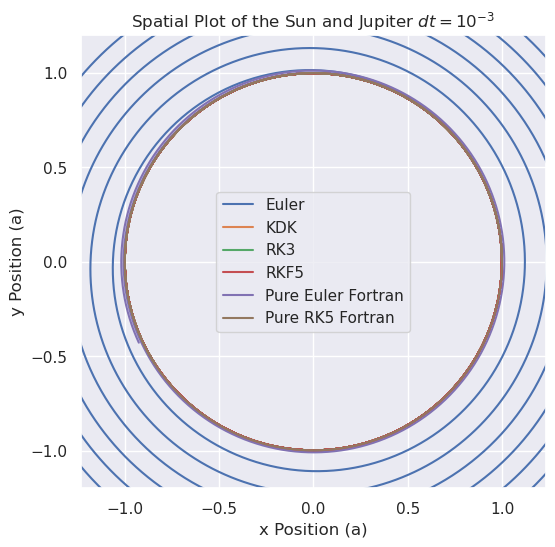

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.plot(euler_circle.positions[:, 1, 0], euler_circle.positions[:, 1, 1],
        label='Euler')
ax.plot(kdk_circle.positions[:, 1, 0], kdk_circle.positions[:, 1, 1],
        label='KDK')
ax.plot(rk3_circle.positions[:, 1, 0], rk3_circle.positions[:, 1, 1],
        label='RK3')
ax.plot(rkf5_circle.positions[:, 1, 0], rkf5_circle.positions[:, 1, 1],
        label='RKF5')
ax.plot(f_poses[:, 1, 0], f_poses[:, 1, 1], label='Pure Euler Fortran')
ax.plot(r_poses[:, 1, 0], r_poses[:, 1, 1], label='Pure RK5 Fortran')
ax.axis('equal')
ax.set_xlabel('x Position (a)')
ax.set_ylabel('y Position (a)')
ax.set_title(r"Spatial Plot of the Sun and Jupiter $dt=10^{-3}$")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend()

## Halley's Comet

In [40]:
# Halley's comet will help distinguish between adaptive and non-adaptive models.
# The only valid solutions are the adaptive Fortran-Python hybrid and the pure
# Fortran model
q = 1e-3
r_aphelion = 1.
e = 0.967
sma = r_aphelion/(1+e)
mean_motion = 1./sma**1.5
v_circ = mean_motion * sma
halley_masses= np.array([1., 0.])
a = 1 / (1 + e)
T_hal = 2 * np.pi * np.sqrt(a**3)
mean_motion = T_hal / 2 / np.pi
vcirc = mean_motion * a
halley_i_pos = np.array([[0., 0., 0.], [1., 0., 0.]])
halley_i_vel = np.array([[0., 0., 0.], 
                         [0., np.sqrt(1/a) * np.sqrt((1-e)/(1+e)), 0.]])
t_tot = 5 * T_hal
dt = 1e-3

euler_halley = n_body(fp.integrators.euler_forward, halley_masses,
                      halley_i_pos, halley_i_vel, t_tot, dt, update_com=True)
kdk_halley = n_body(fp.integrators.kdk, halley_masses,
                    halley_i_pos, halley_i_vel, t_tot, dt, update_com=True)
rk3_halley = n_body(fp.integrators.rk3_classic, halley_masses,
                    halley_i_pos, halley_i_vel, t_tot, dt, update_com=True)
rkf5_halley = n_body(fp.integrators.rkf45, halley_masses,
                     halley_i_pos, halley_i_vel, t_tot, dt, update_com=True)
pyrkf5_halley = n_body(rkf45, halley_masses, halley_i_pos, halley_i_vel, t_tot,
                       dt)
rkf45_halley = adaptive_n_body(fp.integrators.rkf45, halley_masses,
                              halley_i_pos, halley_i_vel, t_tot, 1e-7, 1e-3,
                              update_com=True)
h_times, h_poses, h_vels, h_status = fp.n_bodies.adaptive_n_body_model("rkf45",
        100001, halley_masses, halley_i_pos, halley_i_vel, 100., 1e-10, dt, 4, 
                                                                       1., 1.
    )
h_filt = h_times > 0
h_filt[0] = True
h_times = h_times[h_filt]
h_poses = h_poses[h_filt]
h_vels = h_vels[h_filt]
print(f"RK5 Status: {h_status.decode('utf-8')}")

100%|██████████| 11388/11388 [00:08<00:00, 1380.71it/s]
100% 11.382/11.388 [00:00<00:00, 16.81it/s]


RK5 Status: Ok                                                                                                                                                                                                                                                              


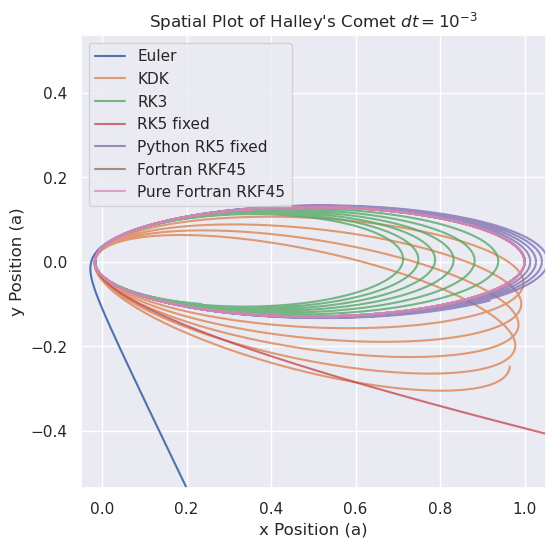

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.plot(euler_halley.positions[:, 1, 0], euler_halley.positions[:, 1, 1],
        label='Euler')
ax.plot(kdk_halley.positions[:, 1, 0], kdk_halley.positions[:, 1, 1],
        label='KDK', alpha=0.8)
ax.plot(rk3_halley.positions[:, 1, 0], rk3_halley.positions[:, 1, 1],
        label='RK3', alpha=0.8)
ax.plot(rkf5_halley.positions[:, 1, 0], rkf5_halley.positions[:, 1, 1],
        label='RK5 fixed', alpha=0.8)
ax.plot(pyrkf5_halley.positions[:, 1, 0], pyrkf5_halley.positions[:, 1, 1],
        label='Python RK5 fixed', alpha=0.8)
ax.plot(rkf45_halley.positions[:, 1, 0], rkf45_halley.positions[:, 1, 1],
        label='Fortran RKF45', alpha=0.8)
ax.plot(h_poses[:, 1, 0], h_poses[:, 1, 1],
        label='Pure Fortran RKF45', alpha=0.8)
ax.axis('equal')
ax.set_xlabel('x Position (a)')
ax.set_ylabel('y Position (a)')
ax.set_title(r"Spatial Plot of Halley's Comet $dt=10^{-3}$")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.1, 0.1)
ax.legend()

## Galaxy Orbits
These use different integrators with different acceleration equations, and they
 are a clear timing benchmark because Python is super slow here.

In [42]:
r = 1.
grav = - np.log(1 + r)/r**2 + 1/(r * (1 + r))
masses = np.array([0., 0.])  # , 0.])
eccentricities = np.array([0., 0.5])
                           # , 0.5, 0.75])
i_positions = np.array([[1., 0., 0.],
                        # [1., 0., 0.],
                        [1., 0., 0.]])
i_velocities = np.array([[0., 1., 0.],
                        #  [0., 1., 0.],
                         [0., 1., 0.]
                            ]) * (np.sqrt(-grav*r)
                                           * np.sqrt((1 - eccentricities)
                           / (1 + eccentricities))[:, None])

dt = 1e-3
galaxy = n_body(fp.integrators.kdk_gal, masses, i_positions, i_velocities, 100,
                dt, update_com=False)
py_galaxy = n_body(kick_drift_kick_galaxy, masses, i_positions, i_velocities, 100,
                dt, update_com=False)

/home/gatlin/miniconda3/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/gatlin/miniconda3/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 100001/100001 [00:30<00:00, 3324.14it/s]


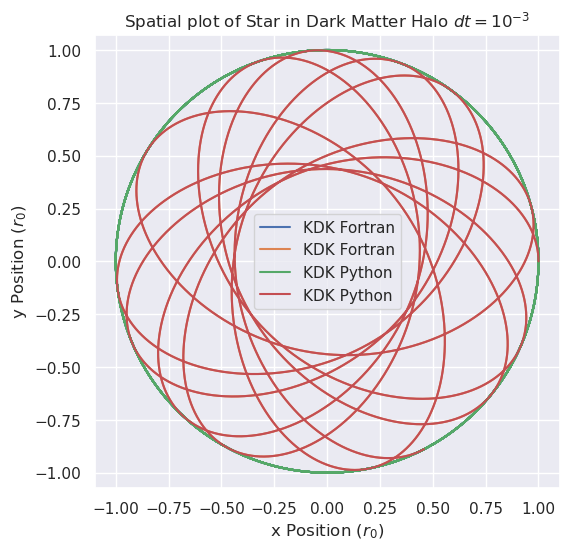

In [43]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.gca()
ax.plot(galaxy.positions[:, :, 0], galaxy.positions[:, :, 1], label='KDK Fortran')
ax.plot(py_galaxy.positions[:, :, 0], py_galaxy.positions[:, :, 1], 
        label='KDK Python')

ax.axis('equal')
ax.set_xlabel(r'x Position ($r_0$)')
ax.set_ylabel(r'y Position ($r_0$)')
ax.set_title(r"Spatial plot of Star in Dark Matter Halo $dt=10^{-3}$")
# ax.set_xlim(-1., 1.)
# ax.set_ylim(-1, 1)
ax.legend()

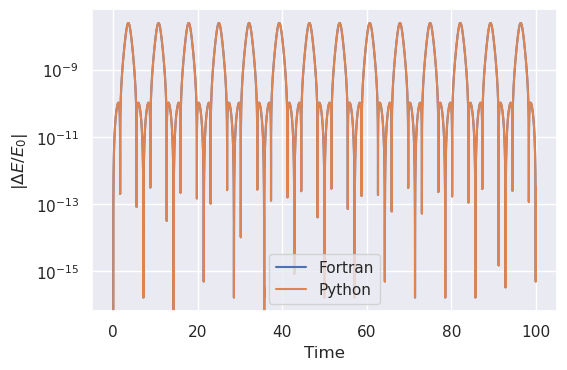

In [44]:
# In this test, the Fortran model and Python model are a perfect match. This
# is expected because on a fundamental level, floats are handled the same,
# regardless of the programming language. It's something you're told in an into
# CS course, but it's cool to see it in practice.
# sma = (1 / (2 / np.linalg.norm(galaxy.positions[:,1,:], axis=1)
r = np.linalg.norm(galaxy.positions[:,1,:], axis=1)
nrg = 0.5 * np.linalg.norm(galaxy.velocities[:,1,:], axis=1)**2
nrg -= (np.log(1 + r) / r)
py_nrg = 0.5 * np.linalg.norm(galaxy.velocities[:,1,:], axis=1)**2
py_nrg -= (np.log(1 + r) / r)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, np.abs((nrg - nrg[0]) / nrg[0]), label='Fortran')
ax.plot(galaxy.times, np.abs((py_nrg - py_nrg[0]) / py_nrg[0]),
        label="Python")
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'$|\Delta E/E_0|$')
ax.legend()

Text(0, 0.5, '$|\\Delta h/h|$')

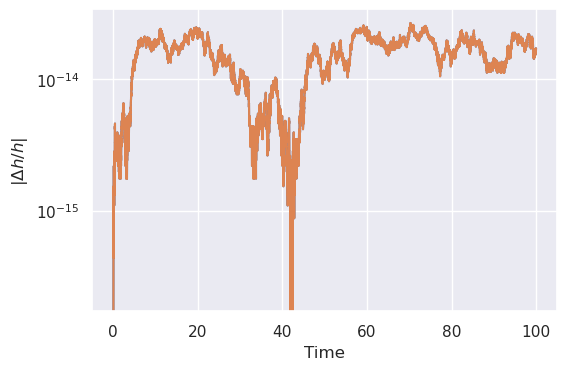

In [45]:
h = np.cross(galaxy.positions, galaxy.velocities, axis=2)[:, 1]
h_mag = np.linalg.norm(h, axis=1)
py_h = np.cross(py_galaxy.positions, py_galaxy.velocities, axis=2)[:, 1]
py_h_mag = np.linalg.norm(h, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, np.abs((h_mag - h_mag[0]) / h_mag))
ax.plot(py_galaxy.times, np.abs((py_h_mag - py_h_mag[0]) / py_h_mag))
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'$|\Delta h/h|$')

## Benchmarks
Some ways of directly comparing performance using the same timing method.
 Jupyter Notebooks have a builtin timing feature meant to mimic the bash script
 `time`. This is our best way of comparing the "Pure Fortran" models run in a
 Jupyter Notebook and the truly pure Fortran run in terminal. The user time is
 what we want here.

In [26]:
# Euler simple circle, a baseline for the rest (and the slowest). Uses Python
# integrator in a non-adaptive Python wrapper
%time n_body(euler_forward, circle_masses, circle_i_pos, circle_i_vel, 100., dt, update_com=True)

100%|██████████| 100001/100001 [00:17<00:00, 5803.80it/s]


CPU times: user 17.5 s, sys: 185 ms, total: 17.7 s
Wall time: 17.7 s


In [27]:
# Fortran euler integrator in a non-adaptive Python wrapper
%time n_body(fp.integrators.euler_forward, circle_masses, circle_i_pos, circle_i_vel, 100., dt, update_com=True)

100%|██████████| 100001/100001 [00:06<00:00, 14993.44it/s]


CPU times: user 7.07 s, sys: 79.8 ms, total: 7.15 s
Wall time: 7.14 s


In [28]:
# A full Fortran non-adaptive integrator and wrapper, run using f2py
# f2py still has some overhead to bring the fortran outputs into Python
%time fp.n_bodies.n_body_model("euler" , 100001, circle_masses, circle_i_pos, circle_i_vel, 100., 1e-3, 1., 1.)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 32 ms


(array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 9.9999e+01, 0.0000e+00,
        0.0000e+00]),
 array([[[-1.00000000e-03,  0.00000000e+00,  0.00000000e+00],
         [ 9.99000000e-01,  0.00000000e+00,  0.00000000e+00]],
 
        [[-1.00000000e-03, -1.00000000e-06,  0.00000000e+00],
         [ 9.99000000e-01,  9.99000000e-04,  0.00000000e+00]],
 
        [[-9.99999000e-04, -2.00000000e-06,  0.00000000e+00],
         [ 9.98999001e-01,  1.99800000e-03,  0.00000000e+00]],
 
        ...,
 
        [[-1.10342664e-03, -3.85863895e-04,  0.00000000e+00],
         [ 1.10232321e+00,  3.85478031e-01,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]),
 array([[[ 0.00000000e+00, -1.00000000e-03,  0.00000000e+00],
         [ 0.00000000e+00,  9.99000000e-01,  0.00000000e+00]],
 
 

In [29]:
# An adaptive Fortran RKF45 integrator in an adaptive Python wrapper. This one
# takes longer than the euler methods, but the accuracy is higher
%time adaptive_n_body(fp.integrators.rkf45, circle_masses, circle_i_pos, circle_i_vel, 100., 1e-7, dt, q=4, update_com=True)

100% 99.991/100.000 [00:00<00:00, 104.22it/s]

CPU times: user 1.05 s, sys: 39.6 ms, total: 1.09 s
Wall time: 998 ms


In [30]:
# Full RKF45 adaptive model in Fortran, brought into Python using f2py. The most
# advanced of the benchmarks
%time fp.n_bodies.adaptive_n_body_model("rkf45", 100001, circle_masses, circle_i_pos, circle_i_vel, 100., 1e-10, dt, 4, 1., 1.)

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 426 ms


(array([6.93309077e-310, 2.28852930e-003, 3.84091641e-003, ...,
        1.10014488e+002, 0.00000000e+000, 0.00000000e+000]),
 array([[[-1.00000000e-03,  0.00000000e+00,  0.00000000e+00],
         [ 9.99000000e-01,  0.00000000e+00,  0.00000000e+00]],
 
        [[-9.99999500e-04, -9.99999883e-07,  0.00000000e+00],
         [ 9.98999500e-01,  9.98999883e-04,  0.00000000e+00]],
 
        [[-9.99994593e-04, -3.28852442e-06,  0.00000000e+00],
         [ 9.98994598e-01,  3.28523589e-03,  0.00000000e+00]],
 
        ...,
 
        [[ 9.98301984e-04,  5.82611778e-05,  0.00000000e+00],
         [-9.97303682e-01, -5.82029166e-02,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]),
 array([[[ 0.00000000e+00, -1.00000000e-03,  0.00000000e+00],
         [ 0.00000000e+00,  9.990000

From the above tests, the fortran models are faster, even in simple models. The
 more fortran used, the faster it is. The fastest test is running this via
 terminal using euler, which clocked in at 0.02s. Unfortunately, this test is
 harder to incorporate in the notebook. Unfortunately, a full-terminal model is
 way harder to work with because we can't use any Python plotting routines with
 it.

## Solar System

Based on the above benchmark, the Fortran adaptive timestep model is ready for
 use, but in order to interact with the data, we will need to run it through
 Python using f2py. This will enable us to plot our outputs easily.

In [18]:
masses = np.array([1.989e33, 0.3302e27, 4.8685e27, 5.9736e27, 0.64185e27, 
                   1898.6e27, 568.46e27, 86.832e27, 102.43e27, 0.01303e27])
ss_masses = masses / masses[0]
sma = np.array([0.0, 0.38709880, 0.72333201, 1.00000083, 1.52368946,
                5.2027584, 9.5428244, 19.19206, 30.06893, 39.48168677])
ecc = np.array([0.0, 0.20563175, 0.00677177, 0.016708617, 0.09340062, 
                0.048495, 0.055509, 0.04630, 0.00899, 0.24880766])
incl = np.array([0.0, 7.00499, 3.39447, 0.0, 1.84973, 1.3033, 2.4889, 
                 0.773, 1.770, 17.14175])
bigomega = np.array([0.0, 48.3309, 76.6799, 0.0, 49.5581, 100.464, 
                     113.666, 74.01, 131.787, 110.30347])
omega = np.array([0.0, 77.4561, 131.5637, 102.9374, 336.6023, 
                  14.331, 93.057, 173.01, 48.12, 224.06676])


In [19]:
ss_masses

array([1.00000000e+00, 1.66013072e-07, 2.44771242e-06, 3.00331825e-06,
       3.22699849e-07, 9.54550025e-04, 2.85801911e-04, 4.36561086e-05,
       5.14982403e-05, 6.55103067e-09])